# Проводим АА тест для проверки корректности работы нашей системы сплитования

# Задачи:
- Взять данные АА-теста с '2022-04-17' по '2022-04-23'
- Сделать симуляцию, как будто мы провели 10000 АА-тестов
- Сформировать подвыборки с повторением в 500 юзеров из 2 и 3 экспериментальной группы
- Провести сравнение этих подвыборок t-testом

In [55]:
#Получаем данные и смотрим на размер групп

import pandahouse
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
                    'database':'simulator_20220520',
                    'user':'student', 
                    'password':'dpo_python_2020'
}

q = '''SELECT user_id, 
            exp_group,
            sum(action = 'like') as likes,
            sum(action = 'view') as view,
            likes/view as ctr
        FROM {db}.feed_actions
        where toDate(time) >= '2022-04-17' and toDate(time) <= '2022-04-23' and exp_group in (2,3)
        group by user_id, exp_group
        '''

df = pandahouse.read_clickhouse(q, connection=connection)
df.groupby('exp_group').count()

,user_id,likes,view,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


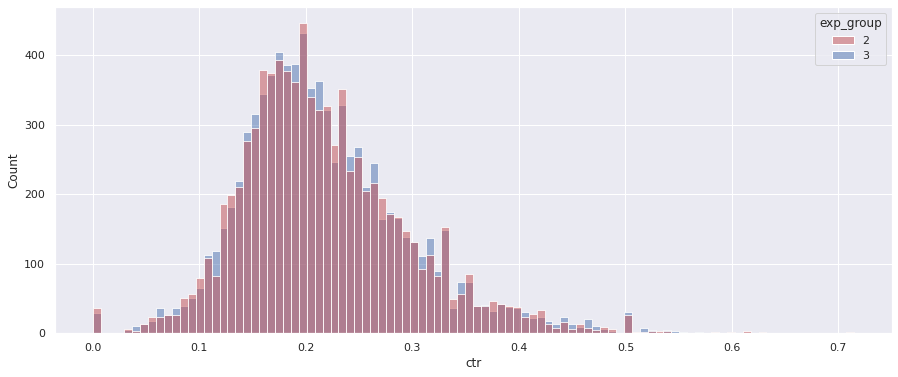

In [25]:
#Построим график наших 2-х групп
#Как мы видим распределение 2-х групп практически одинаковое

sns.set(rc = {'figure.figsize':(15, 6)})

groups = sns.histplot(data = df, x = 'ctr', hue = 'exp_group', palette = ['r', 'b'], alpha = 0.5, kde = False)

In [59]:
#Далее делаем симуляцию 10 000 АА тестов и на каждой итерации берём подвыборки по 500 юзеров из каждой группы.

lst = []
for _ in range(10000):
    p_val = round(stats.ttest_ind(df[df.exp_group == 2].ctr.sample(500, replace = True),
                df[df.exp_group == 3].ctr.sample(500, replace = True),
                equal_var=False)[1],2)
    
    lst.append(p_val)
    df1 = pd.DataFrame(lst, columns = ['p_val'])
df1.head(2)

,p_val
0,0.43
1,0.33


In [58]:
#Смотрим какой % у нас P value < 0,05%

p_value = round(df1[df1.p_val <= 0.05].shape[0]/df1.shape[0]*100,2)
p_value

5.68

<AxesSubplot:xlabel='p_val', ylabel='Count'>

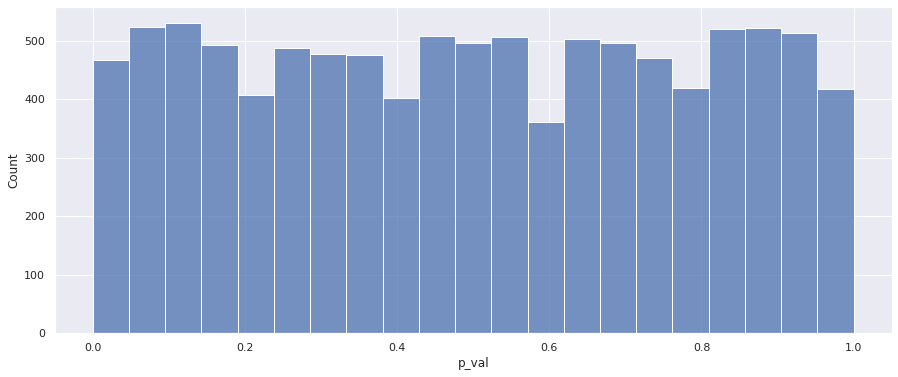

In [57]:
#Строим график распределения 10 000 P-values

sns.set(rc = {'figure.figsize':(15, 6)})
sns.histplot(data = df1, x = 'p_val')

При анализе корректности работы нашей системы сплитования АА тест показал следующие результы:
1. Процент P-value < 0,05% у нас оказался 5,68%. Это говорит о том, что статистически значимые различия получились чуть более, чем в 5% случаев.
2. На основе данного вывода можем считать, что группы разбиты правильно и статистически незначимые различия лежат в 95% случаях.
3. По итогу вышеперечисленных выводов можем переходить к АБ тесту.